In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

c:\Users\sugay\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 指定されたプロシージャが見つかりません。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# cudaが使えるか確認
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

データの読み込み

GPUで作ったPickleのファイルは，CPUではそのままでは使えないため，工夫が必要．

https://www.kunita-gamefactory.com/post/%E3%80%90pytorch%E3%80%91gpu%E3%81%A7%E8%A8%93%E7%B7%B4%E3%81%95%E3%81%9B%E3%81%9F%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92cpu%E3%81%A7%E8%AA%AD%E3%81%BF%E8%BE%BC%E3%82%82%E3%81%86%E3%81%A8%E3%81%97%E3%81%9F%E3%81%8A%E8%A9%B1

を真似したらうまくCPU上でもファイルを読み込むことができるようになった．

In [3]:
import io
        
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [4]:
# ファイルの相対パスを指定
file_path = '../data storage/Ising_data_L16_v2.pkl'

if torch.cuda.is_available():
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
else:
    with open(file_path, 'rb') as file:
        loaded_data = CPU_Unpickler(file).load()
        
# 読み込んだデータを個々の変数に分割
spin_data, label_data = loaded_data

In [5]:
# # 磁化を計算
# def magnetization(state):
#     return np.mean(state)

# for i in range(len(spin_data)):
#     mag = magnetization(spin_data[i])
#     if mag > 0:
#         spin_data[i] *= -1

In [6]:
# plt.imshow(spin_data[17], cmap='gray', interpolation='nearest')
# plt.show()

In [7]:
# データのリストをNumPy配列に変換
spin_data_np = np.array(spin_data)
label_data_np = np.array(label_data)

# NumPy配列をPyTorchテンソルに変換
spin_data_tensor = torch.from_numpy(spin_data_np)
label_data_tensor = torch.from_numpy(label_data_np)

In [8]:
# spin_data_tensor = spin_data_tensor.unsqueeze(1)
# spin_data_tensor.shape

In [9]:
# サンプルデータを訓練用とテスト用に分割(5:5)
spin_train, spin_test, label_train, label_test = train_test_split(spin_data_tensor, label_data_tensor, test_size=0.5)

In [10]:
# PyTorchのテンソルに変換
spin_train = torch.tensor(spin_train, dtype=torch.float32)
spin_test = torch.tensor(spin_test, dtype=torch.float32)
label_train = torch.tensor(label_train, dtype=torch.float32)  
label_test = torch.tensor(label_test, dtype=torch.float32)    

C:\Users\sugay\AppData\Local\Temp\ipykernel_9060\168836570.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_train = torch.tensor(spin_train, dtype=torch.float32)
C:\Users\sugay\AppData\Local\Temp\ipykernel_9060\168836570.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_test = torch.tensor(spin_test, dtype=torch.float32)
C:\Users\sugay\AppData\Local\Temp\ipykernel_9060\168836570.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_train = torch.tensor(label_train, dtype=torch.float32)
C:\Users\sugay\AppData\Local\Temp\

正解データはone-hot表現にする必要がある

In [11]:
# テンソルを新しいテンソルに変換する関数を定義
def to_one_hot(data, num_classes=20):
    # one-hotベクトルの初期化
    one_hot = torch.zeros(len(data), num_classes)
    print(one_hot.size())
    # 各要素を20次元のone-hotベクトルに変換
    for i, val in enumerate(data):
        index = int(torch.round((val - 0.05) / 0.05))
        one_hot[i, index] = 1.0
    
    return one_hot

# label_train,temp_testをone-hotベクトルに変換
one_hot_label_train = to_one_hot(label_train, num_classes=20)
one_hot_label_test = to_one_hot(label_test, num_classes=20)

torch.Size([20000, 20])
torch.Size([20000, 20])


In [12]:
# データセットの作成
train_dataset = TensorDataset(spin_train, one_hot_label_train)
test_dataset = TensorDataset(spin_test, one_hot_label_test)

In [13]:
# 前処理を定義
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

# データセットに前処理を適用
transformed_train_dataset = [(transform(tensor_sample), label) for tensor_sample, label in train_dataset]
transformed_test_dataset = [(transform(tensor_sample), label) for tensor_sample, label in test_dataset]

In [14]:
# DataLoaderの設定
train_loader = DataLoader(transformed_train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(transformed_test_dataset, batch_size=8)

In [15]:
# # 前処理なしver
# # DataLoaderの設定（バッチサイズ50）
# train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=50)

モデルを定義

In [16]:
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.fc2 = nn.Linear(hidden_size, output_size, bias=True)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = F.softmax(self.fc1(x), dim=1)
        x = F.softmax(self.fc2(x), dim=1)
        return x

モデルのインスタンス化

In [17]:
input_size = 16*16
# hidden_size = 80
hidden_size = 3
output_size = 20
model = FCNN(input_size, hidden_size, output_size)
# model.to(device)
# モデルの概要表示
print(model)

FCNN(
  (fc1): Linear(in_features=256, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=20, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


損失関数と最適化アルゴリズムの設定

In [18]:
criterion = nn.CrossEntropyLoss()   # クロスエントロピー誤差
optimizer = optim.Adam(model.parameters(), lr=0.001)     # Adam,L2正則化{, weight_decay=5e-4}

学習の実行

In [19]:
num_epochs = 20
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)      
        targets = torch.argmax(targets, dim=1) 
        running_acc += torch.mean(pred.eq(targets).float().cpu()) 
        optimizer.step()
    running_loss /= len(train_loader)   
    running_acc /= len(train_loader)    
    train_losses.append(running_loss)
    train_accs.append(running_acc)
    #
    #   test loop
    #
    test_running_loss = 0.0
    test_running_acc = 0.0
    for test_inputs, test_targets in test_loader:
        test_inputs = test_inputs.to(device)
        test_targets = test_targets.to(device)
        test_output = model(test_inputs)
        test_loss = criterion(test_output, test_targets)
        test_running_loss += test_loss.item()
        test_pred = torch.argmax(test_output, dim=1)      
        test_targets = torch.argmax(test_targets, dim=1)  
        test_running_acc += torch.mean(test_pred.eq(test_targets).float().cpu()) 
    test_running_loss /= len(test_loader)   
    test_running_acc /= len(test_loader)    
    test_losses.append(test_running_loss)
    test_accs.append(test_running_acc)
        
    print("epoch: {}, loss: {}, acc: {}, test loss: {}, test acc: {}".format(epoch, running_loss, running_acc, test_running_loss, test_running_acc))

epoch: 0, loss: 2.985087525177002, acc: 0.08569999784231186, test loss: 2.9678556922912596, test acc: 0.0966000035405159
epoch: 1, loss: 2.958570684528351, acc: 0.10170000046491623, test loss: 2.954350315475464, test acc: 0.09950000047683716
epoch: 2, loss: 2.950890757369995, acc: 0.1018500030040741, test loss: 2.950586573314667, test acc: 0.09875000268220901
epoch: 3, loss: 2.9482103350639344, acc: 0.10145000368356705, test loss: 2.949077602481842, test acc: 0.09920000284910202
epoch: 4, loss: 2.9467571352005004, acc: 0.1046999990940094, test loss: 2.948276547622681, test acc: 0.10289999842643738
epoch: 5, loss: 2.9453779204368593, acc: 0.11050000041723251, test loss: 2.9472277252197268, test acc: 0.10999999940395355
epoch: 6, loss: 2.944069890213013, acc: 0.11860000342130661, test loss: 2.94609420003891, test acc: 0.11524999886751175
epoch: 7, loss: 2.9426348685264587, acc: 0.12504999339580536, test loss: 2.944705028152466, test acc: 0.12075000256299973
epoch: 8, loss: 2.941176124477

モデルの保存

In [20]:
Ising_size = int(np.sqrt(input_size))
print(Ising_size)
class_name = type(model).__name__
print(class_name)
print(hidden_size)

file_path = f'../data storage/prm_data_L{Ising_size}_{class_name}_Nh{hidden_size}.pth'

torch.save(model.state_dict(), file_path)

16
FCNN
3


In [21]:
# ファイルの相対パスを指定
file_path = '../data storage/Ising_data_L16_v2.pkl'

if torch.cuda.is_available():
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
else:
    with open(file_path, 'rb') as file:
        loaded_data = CPU_Unpickler(file).load()
        
# 読み込んだデータを個々の変数に分割
spin_data, label_data = loaded_data

In [22]:
# データのリストをNumPy配列に変換
spin_data_np = np.array(spin_data)
label_data_np = np.array(label_data)

# NumPy配列をPyTorchテンソルに変換
spin_data_tensor = torch.from_numpy(spin_data_np)
label_data_tensor = torch.from_numpy(label_data_np)

In [23]:
# サンプルデータを訓練用とテスト用に分割(5:5)
spin_train, spin_test, label_train, label_test = train_test_split(spin_data_tensor, label_data_tensor, test_size=0.5)

In [24]:
# PyTorchのテンソルに変換
spin_train = torch.tensor(spin_train, dtype=torch.float32)
spin_test = torch.tensor(spin_test, dtype=torch.float32)
label_train = torch.tensor(label_train, dtype=torch.float32)  
label_test = torch.tensor(label_test, dtype=torch.float32)   

C:\Users\sugay\AppData\Local\Temp\ipykernel_9060\492345606.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_train = torch.tensor(spin_train, dtype=torch.float32)
C:\Users\sugay\AppData\Local\Temp\ipykernel_9060\492345606.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_test = torch.tensor(spin_test, dtype=torch.float32)
C:\Users\sugay\AppData\Local\Temp\ipykernel_9060\492345606.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_train = torch.tensor(label_train, dtype=torch.float32)
C:\Users\sugay\AppData\Local\Temp\

In [25]:
spin_train_np = spin_train.numpy()
label_train_np = label_train.numpy()

In [26]:
flat_spin_train_np = [spin_train_np[i].flatten() for i in range(len(spin_train_np))]
flat_spin_train_np[0].shape

(256,)

In [27]:
len(label_train_np)

20000

In [28]:
prm = torch.load('../data storage/prm_data_L16_FCNN_Nh3.pth')
fc1_weight = prm['fc1.weight'].numpy()
fc1_bias = prm['fc1.bias'].numpy()

In [29]:
# 磁化を計算
def magnetization(state):
   return np.mean(state)

In [30]:
# 内積
output_data_0 = []
output_data_1 = []
output_data_2 = []
mag_data = []

for i in range(len(label_train_np)):
    dot_product_0 = np.dot(flat_spin_train_np[i], fc1_weight[0]) + fc1_bias[0]
    output_data_0.append(dot_product_0)
    dot_product_1 = np.dot(flat_spin_train_np[i], fc1_weight[1]) + fc1_bias[1]
    output_data_1.append(dot_product_1)
    dot_product_2 = np.dot(flat_spin_train_np[i], fc1_weight[2]) + fc1_bias[2]
    output_data_2.append(dot_product_2)
    mag = magnetization(flat_spin_train_np[i])
    mag_data.append(mag)

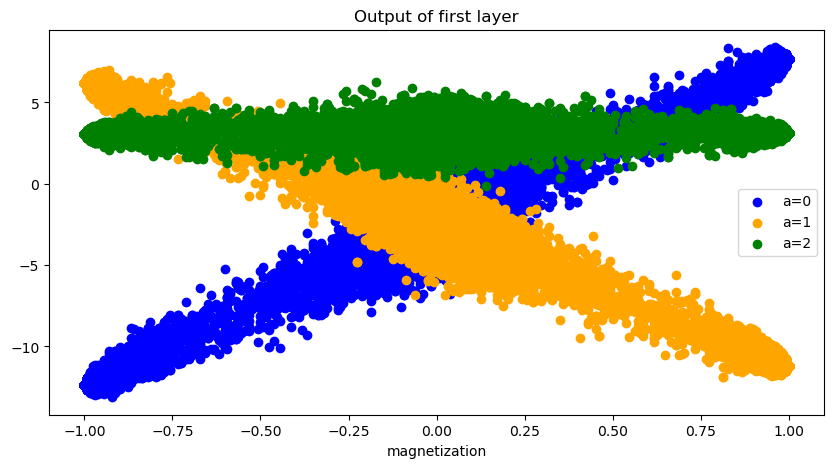

In [31]:
# データ
x = mag_data
y0 = output_data_0
y1 = output_data_1
y2 = output_data_2

# プロット
plt.figure(figsize=(10, 5))
plt.scatter(x, y0, color='blue', label='a=0')
plt.scatter(x, y1, color='orange', label='a=1')
plt.scatter(x, y2, color='green', label='a=2')


plt.title('Output of first layer')
plt.xlabel('magnetization')

# 図をファイルとして保存
plt.savefig('../image/L16_FCNN_Nh3_output.png')
plt.legend()  # 凡例を表示
plt.show()